# Linear Model with Lexicon Term Frequencies

In [1]:
import os
import re
import pathlib
import warnings
warnings.filterwarnings(action="ignore")

import pprint
import itertools
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def annotateBars(ax, fmt="{:.0f}", percent=False): 
    for p in ax.patches:
        value = p.get_height()
        if percent:
            value = f"{value * 100:.0f}%"
        else:
            value = fmt.format(value)
            
        ax.annotate(value, 
                    (p.get_x() + p.get_width() / 2., 0),
                    ha='center', va='center', fontsize=22, color='black', xytext=(0, 20), textcoords='offset points')
        
def pretty_plot(ax, title, xlab, ylab, sizes=(18, 14, 13)):
    ax.set_title(title, fontsize=sizes[0], y=1.01)
    ax.set_xlabel(xlab, fontsize=sizes[1])
    ax.set_ylabel(ylab, fontsize=sizes[1])

    ax.tick_params(axis="x", labelsize=sizes[2])
    ax.tick_params(axis="x", labelsize=sizes[2])

### I want to predict the society label for peaceful and nonpeaceful countries using the frequencies of the words in the lexicons.

## Prep Data

In [3]:
word_counts = pd.read_csv("../data/word_counts_by_article.csv")
lexicon = pd.read_csv("../lexicons/lexicon.csv")

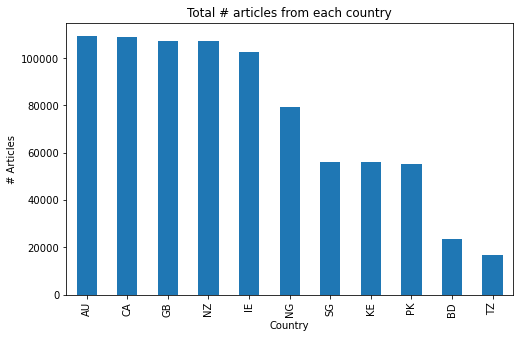

In [4]:
word_counts.country.value_counts().plot(kind="bar", figsize=(8, 5),
                                        title="Total # articles from each country", 
                                        xlabel="Country", ylabel="# Articles");

I randomly sample 75,000 articles from each society, where each country has the same number of articles.

In [5]:
resample = []

N = 75_000
for society, society_df in word_counts.groupby("society"):
    num_countries = society_df.country.unique().shape[0]
    num_to_sample = int(np.floor(N / num_countries))
    
    for country, country_df in tqdm(society_df.groupby("country"), desc=f"Getting sample for {society.upper()}"):
        if country_df.shape[0] >= num_to_sample:
            df = country_df.sample(num_to_sample, random_state=2020)
        else:
            df = country_df
            
        resample.append(df)

del word_counts
word_counts = pd.concat(resample)

Getting sample for PEACEFUL: 100%|███████████████████████████████████████████████████████| 6/6 [01:31<00:00, 15.17s/it]


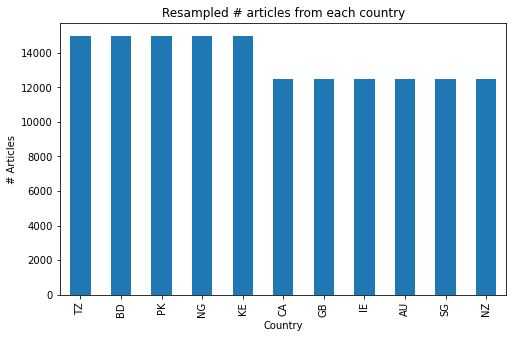

In [6]:
word_counts.country.value_counts().plot(kind="bar", figsize=(8, 5),
                                        title="Resampled # articles from each country", 
                                        xlabel="Country", ylabel="# Articles");

The data is in a wide format already, with each column being a word and each row is an article. The values are the counts of that word in that article.

In [7]:
word_counts.head()

,academic freedom,acceptance,accepting,active listening,activism,advocate,agree,agreed,agreeing,agreement,...,trade,bank,benefit,reduce,develop,land,source,society,country,year
121240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Nonpeaceful,BD,2013
116714,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,0,0,Nonpeaceful,BD,2012
127724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Nonpeaceful,BD,2011
122645,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Nonpeaceful,BD,2014
129808,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,Nonpeaceful,BD,2020


In [8]:
X = word_counts.iloc[:, :-3]
y = word_counts.iloc[:, -3]

#### To speed things up, I am going to drop the words that do not appear often (if ever) in the sample. 

In [9]:
X_tot_word_counts = X.stack().reset_index()
X_tot_word_counts.columns = ["article", "term", "n"]
X_tot_word_counts = X_tot_word_counts.groupby("term")

n = X_tot_word_counts.n.sum().rename("n").reset_index().set_index("term")
n_articles = X_tot_word_counts.n.apply(lambda x: (x > 0).sum()).rename("n_articles").reset_index().set_index("term")

X_tot_word_counts = n.join(n_articles).reset_index()

Let's quickly visualize how many words might be worth dropping.

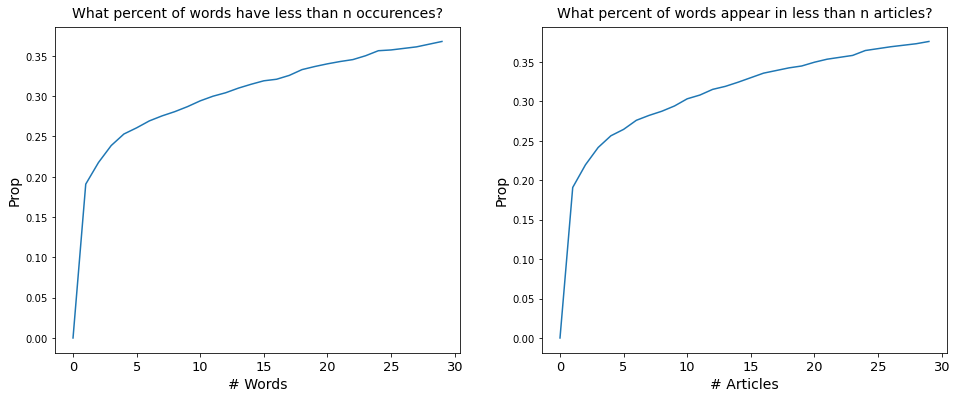

In [10]:
def get_pct_lt_n_words(x):
    return X_tot_word_counts[X_tot_word_counts.n < x].shape[0] / X.shape[1]

def get_pct_lt_n_articles(x):
    return X_tot_word_counts[X_tot_word_counts.n_articles < x].shape[0] / X.shape[1]

xs = np.arange(0, 30)
ns = [get_pct_lt_n_words(n) for n in xs]
n_articles = [get_pct_lt_n_articles(n) for n in xs]

fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
sns.lineplot(xs, ns, ax=axes[0])
pretty_plot(axes[0], "What percent of words have less than n occurences?", "# Words", "Prop", sizes=(14, 14, 13))

sns.lineplot(xs, n_articles, ax=axes[1])
pretty_plot(axes[1], "What percent of words appear in less than n articles?", "# Articles", "Prop", sizes=(14, 14, 13))

Arbitrarily, I am going with words must appear in atleast 5 articles.

In [11]:
pct = get_pct_lt_n_articles(5)
print(f"{pct * 100:.1f}%")

26.4%


What is getting removed?

In [12]:
pp = pprint.PrettyPrinter(compact=True, width=180)

X_tot_word_counts_ = X_tot_word_counts.merge(lexicon, on="term")[["version", "lexicon", "term", "n", "n_articles"]]
for g, df in X_tot_word_counts_[X_tot_word_counts_.n_articles < 5].groupby(["version", "lexicon"]):
    print(" ".join(g).title())
    if df.empty:
        print(set())
    else:
        pp.pprint(set(df.sample(25).term.tolist()))
    print()

Old Conflict
{'anarchism', 'battleful', 'collective violence', 'cyber-terrorism', 'discriminately', 'disputer', 'disruptability', 'disruptable', 'ethno-nationalists', 'hostileness', 'inequal',
 'infringer', 'intractable conflict', 'martyrizer', 'moral exclusion', 'mortality salience', 'oppressible', 'pirates', 'rigid institutions', 'shoot down', 'social dominance',
 'stooges', 'strangling', 'suffocative', 'suicidalism'}

Old Peace
{'civilness', 'collaborative governance', 'collectiveness', 'communalize', 'communalizer', 'constructiveness', 'dialogue groups', 'divineness', 'epistemic communities',
 'generousness', 'global ethic', 'intergroup contact', 'knowledgeably', 'literary works', 'mutualize', 'peace encyclopedist', 'peace parks', 'peace vision', 'peaceful globalizer',
 'positive contact', 'reciprocalize', 'reciprocator', 'respectfulness', 'role models', 'uniter'}

Old Resilience
{'accountableness', 'anti militarism', 'batna', 'civil resistance', 'civil-military cooperation', 'coll

How much data did I remove?

In [13]:
print("Old X shape", X.shape)
X_ = X[X_tot_word_counts[X_tot_word_counts.n_articles >= 5].term]
print("New X shape", X_.shape)

Old X shape (150000, 2091)
New X shape (150000, 1538)


## Begin Modeling

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import GridSearchCV

### Model Selection

I train a Logistic Regression and Random Forest with 10 fold cross-validation to selct the model.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, stratify=y, random_state=116)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (112500, 1538)
y_train (112500,)
X_test (37500, 1538)
y_test (37500,)


In [16]:
y_train.value_counts()

Nonpeaceful    56250
Peaceful       56250
Name: society, dtype: int64

In [17]:
pipeline = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('scale', StandardScaler(with_mean=False)),
    ('model', DummyClassifier())
])

grid = {
    "model": [
        DummyClassifier(),
        LogisticRegression(),
        RandomForestClassifier()
    ]
}

gs = GridSearchCV(pipeline, grid, cv=10, scoring=["accuracy", "f1"], n_jobs=-1, verbose=100, return_train_score=True, refit="f1")
gs.fit(X_train, y_train == "Peaceful");

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done   8 out of  30 | elapsed:   30.5s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:   30.6s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:   30.7s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   33.3s remaining:   57.6s
[Parallel(n_jobs=-1)]: Done  12 out of  30 | elapsed:   34.5s remaining:   51.8s
[Parallel(n_jobs=-1)]: 

In [18]:
def tidy_cv_result(cv_result, split_type, metric="score", nfolds=10):
    regex = r"split[\d]+_{:}_{:}".format(split_type, metric)
    cols = ["param_model"] + [c for c in cv_result.columns if re.match(regex, c)]
    res = cv_result[cols]
    res.columns = ["model"] + [str(i) for i in range(nfolds)]
    res["model"] = res.model.astype(str).str.slice(0, -2)
    res = res.set_index("model").stack().reset_index()
    res.columns = ["model", "split", "score"]
    res["split_type"] = split_type
    
    return res[["model", "split_type", "split", "score"]]

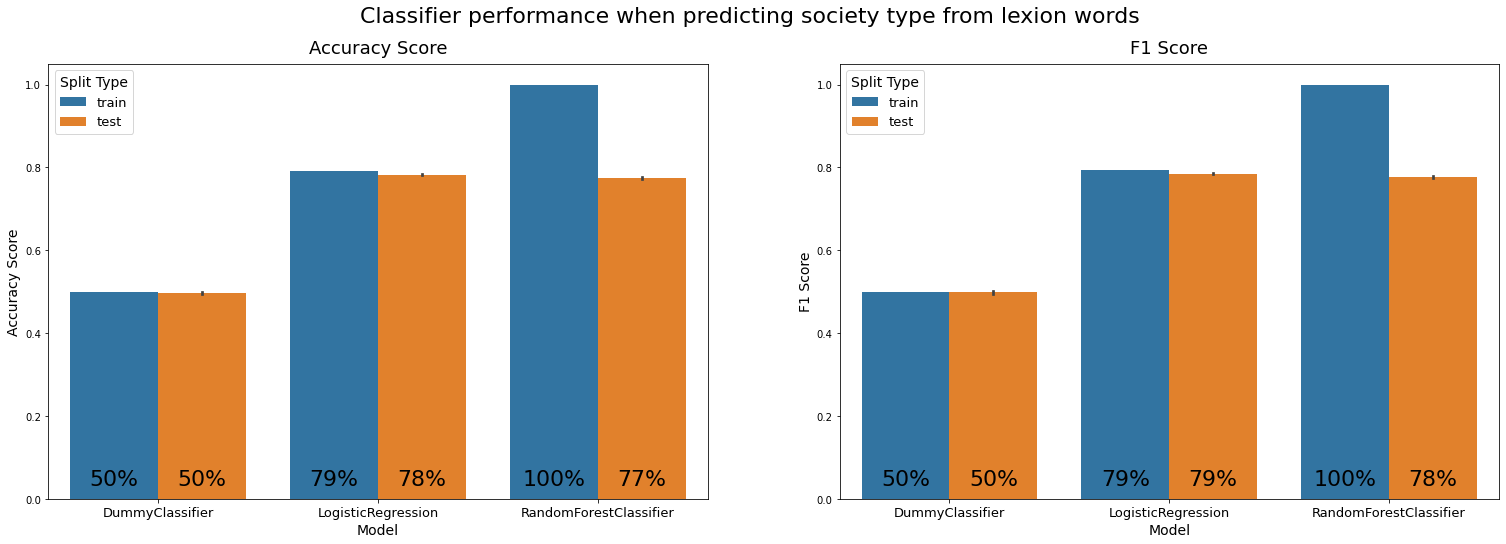

In [19]:
res = pd.DataFrame(gs.cv_results_)

res_acc = pd.concat([
    tidy_cv_result(res, "train", "accuracy"),
    tidy_cv_result(res, "test",  "accuracy"),
])

res_f1 = pd.concat([
    tidy_cv_result(res, "train", "f1"),
    tidy_cv_result(res, "test",  "f1"),
])

fig, axes = plt.subplots(ncols=2, figsize=(26, 8))
title = "Classifier performance when predicting society type from lexion words"

sns.barplot(x="model", y="score", hue="split_type", data=res_acc, ax=axes[0])
pretty_plot(axes[0], "Accuracy Score", "Model", "Accuracy Score")
annotateBars(axes[0], percent=True)

legend = axes[0].legend(title="Split Type", loc="upper left", fontsize=13)
legend.get_title().set_fontsize(14)

sns.barplot(x="model", y="score", hue="split_type", data=res_f1, ax=axes[1])
pretty_plot(axes[1], "F1 Score", "Model", "F1 Score")
annotateBars(axes[1], percent=True)

legend = axes[1].legend(title="Split Type", loc="upper left", fontsize=13)
legend.get_title().set_fontsize(14)

plt.suptitle(title, fontsize=22);

### Model Evaluation

In [20]:
pipeline = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('scale', StandardScaler(with_mean=False)),
    ('model', LogisticRegressionCV())
])

pipeline.fit(X_train, y_train);
lr_fit = pipeline.named_steps["model"]

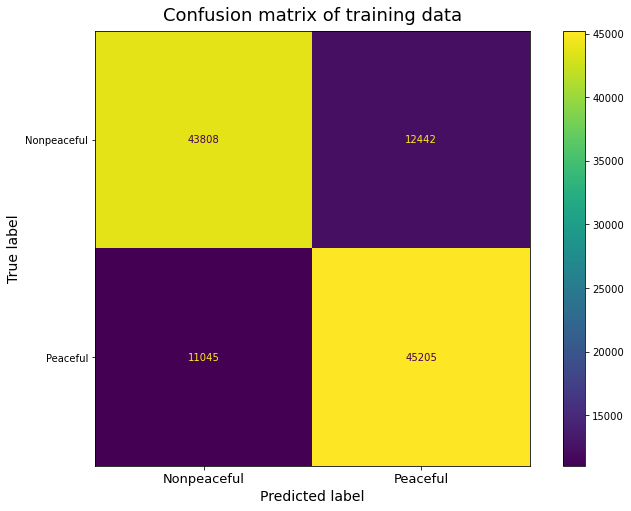

In [21]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(12, 8))
pretty_plot(ax, "Confusion matrix of training data", "Predicted Label", "True Label")
plot_confusion_matrix(pipeline, X_train, y_train, ax=ax);

In [22]:
term_coef = pd.DataFrame(
    np.column_stack([
        X_train.columns,
        lr_fit.coef_.reshape(-1)
    ]), columns=["term", "coef"]
)

term_coef = term_coef.merge(
    lexicon.drop("num_words", axis=1), 
    on="term", 
    how="left"
)

colors = {
    "peace": "#6db7f7", 
    "resilience": "#36CB8A", 
    "conflict": "#FF5A59"
}

term_coef["coef"] = term_coef["coef"].astype(float)
term_coef["abs_coef"] = np.abs(term_coef.coef)
term_coef["sign_coef"] = term_coef.coef.apply(lambda x: "POS" if np.sign(x) > 0 else "NEG")
term_coef["importance_rank"] = term_coef.abs_coef.rank(method="min", ascending=False)
term_coef["bar_color"] = term_coef.lexicon.apply(lambda x: colors[x])
term_coef = term_coef.drop_duplicates("term", keep=False)

term_coef = term_coef.sort_values("abs_coef", ascending=False)

term_coef.head()

,term,coef,lexicon,version,abs_coef,sign_coef,importance_rank,bar_color
861,islam,-0.250519,peace,old,0.250519,NEG,1.0,#6db7f7
910,liberal,0.184448,peace,old,0.184448,POS,2.0,#6db7f7
1431,state,-0.168785,conflict,new,0.168785,NEG,3.0,#FF5A59
9,accord,-0.153134,conflict,new,0.153134,NEG,4.0,#FF5A59
656,fruit,-0.141766,conflict,new,0.141766,NEG,5.0,#FF5A59


### FOR EASE, terms that apper in multiple lexicons are removed.

For terms where their coefficients go to 0, what lexicons are they coming from? Remember, all these words were present in the sample!

In [23]:
term_coef[term_coef.coef == 0].groupby(["version", "lexicon"]).size()

Series([], dtype: int64)

What are some of these words?

In [24]:
pp = pprint.PrettyPrinter(compact=True, width=200)

for g, df in term_coef[term_coef.coef == 0].groupby("lexicon"):
    print(g.upper())
    pp.pprint(set(df.term.tolist()))
    print()

**All the zero-coef terms are from the old lexicon.**

How do the most important terms drive our prediction? Are these drivers consistent with our lexicons?

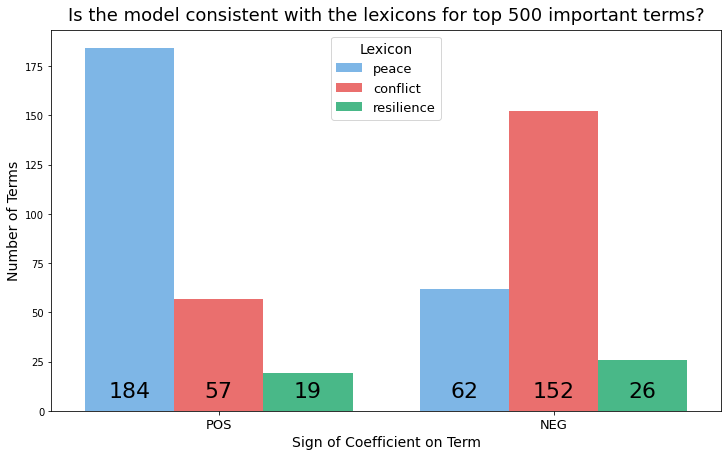

In [25]:
lexicon_consistency = term_coef.sort_values("abs_coef", ascending=False).head(500)
lexicon_consistency = lexicon_consistency.groupby(["sign_coef", "lexicon"]).size().rename("n").reset_index()
lexicon_consistency = lexicon_consistency.sort_values(["sign_coef", "n"], ascending=False)
lexicon_consistency["bar_color"] = lexicon_consistency.lexicon.apply(lambda x: colors[x])

fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(
    x="sign_coef", 
    y="n",
    hue="lexicon",
    palette=lexicon_consistency.bar_color,
    data=lexicon_consistency
)

title = "Is the model consistent with the lexicons for top 500 important terms?"
pretty_plot(ax, title, "Sign of Coefficient on Term", "Number of Terms")

legend = plt.legend(title="Lexicon", loc="upper center", fontsize=13)
legend.get_title().set_fontsize(14)

annotateBars(ax)

For the top 500 terms from the logistic regression model, we see that the vast majority of terms with a positive coefficient are from the peace lexicon, and similarly the terms with negative coefficients are mostly from the conflict lexicon. This seems to imply that our lexicons are doing a good job of separating the two types of countries. For this model, positive coefficients increase the probability of being a 'peaceful' country, so it looks like our peaceful terms drive the probability up while conflict terms tend to drive it down. It is also interesting that the resillience lexicon appears evenly in both groups.

Next are some actual words and how their pressence drives the probability of being a peaceful nation. The bars are colored by lexicon, so that we see the trend discussed above. 

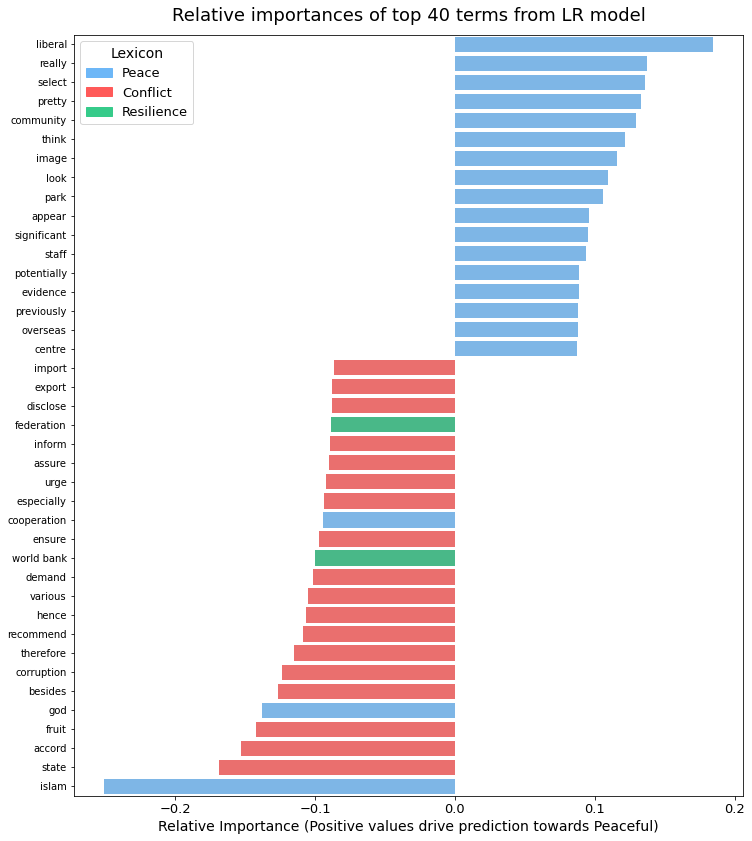

In [26]:
top_coef = term_coef.sort_values("abs_coef", ascending=False).head(40)
top_coef = top_coef.sort_values("coef", ascending=False)

fig, ax = plt.subplots(figsize=(12, 14))
sns.barplot(x="coef", y="term", palette=top_coef.bar_color, data=top_coef, ax=ax)

title = "Relative importances of top 40 terms from LR model"
xlab = "Relative Importance (Positive values drive prediction towards Peaceful)"

labels = ["Peace", "Conflict", "Resilience"]
handles = [plt.Rectangle((0,0),1,1, color=colors[label.lower()]) for label in labels]
           
legend = plt.legend(handles, labels, title="Lexicon", loc="upper left", fontsize=13)
legend.get_title().set_fontsize(14)

pretty_plot(ax, title, xlab, None)

Lastly, how important is each lexicon and version combination?

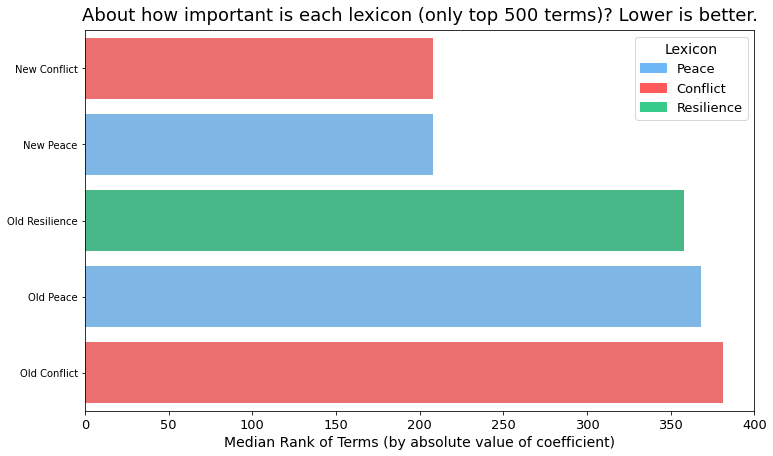

In [27]:
lexicon_importance = term_coef.sort_values("abs_coef", ascending=False).head(500)
lexicon_importance = lexicon_importance.groupby(["version", "lexicon"]).importance_rank.median().rename("avg_rank").reset_index()
lexicon_importance["avg_rank"] = np.around(lexicon_importance.avg_rank).astype(int)
lexicon_importance["name"] = lexicon_importance.version.str.title() + " " + lexicon_importance.lexicon.str.title()
lexicon_importance["bar_color"] = lexicon_importance.lexicon.apply(lambda x: colors[x])
lexicon_importance = lexicon_importance.sort_values("avg_rank")

fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(
    x="avg_rank", 
    y="name",
    palette=lexicon_importance.bar_color,
    data=lexicon_importance
)

title = "About how important is each lexicon (only top 500 terms)? Lower is better."
pretty_plot(ax, title, "Median Rank of Terms (by absolute value of coefficient)", None)

labels = ["Peace", "Conflict", "Resilience"]
handles = [plt.Rectangle((0,0),1,1, color=colors[label.lower()]) for label in labels]
           
legend = plt.legend(handles, labels, title="Lexicon", fontsize=13)
legend.get_title().set_fontsize(14)


I don't know. My takeaway here is that terms in the new lexicon tend to have much larger coefficients than terms from the old lexicon.